In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [28]:
df = pd.read_csv('Cleaned Datasets/Merged_data.csv')
# Extract data for USA and Japan
USA = df[df['Country'] == "UNITED STATES"].reset_index()
JAPAN = df[df['Country'] == "JAPAN"].reset_index()
# Only use GDP data
USA = USA[['Country', 'Year', 'GDP']]
JAPAN = JAPAN[['Country', 'Year', 'GDP']]

# Classical Decomposition - Multiplicative model

We begin with a preliminary analysis of GDP trends using a classical decompoisition model. Since GDP generally grows exponentially (see figure GDPFIGURE), we will take the natural log of GDP to get our model into the following additive form:

$$ log(GDP)_t = T_t + S_t + R_t $$

In this model, $T_t$ represents the trend, $S_t$ represents a seasonal component, and $R_t$ is the remainder. 

Figure GDPFIGURE shows the GDP trends of two example countries: The United States, and Japan:

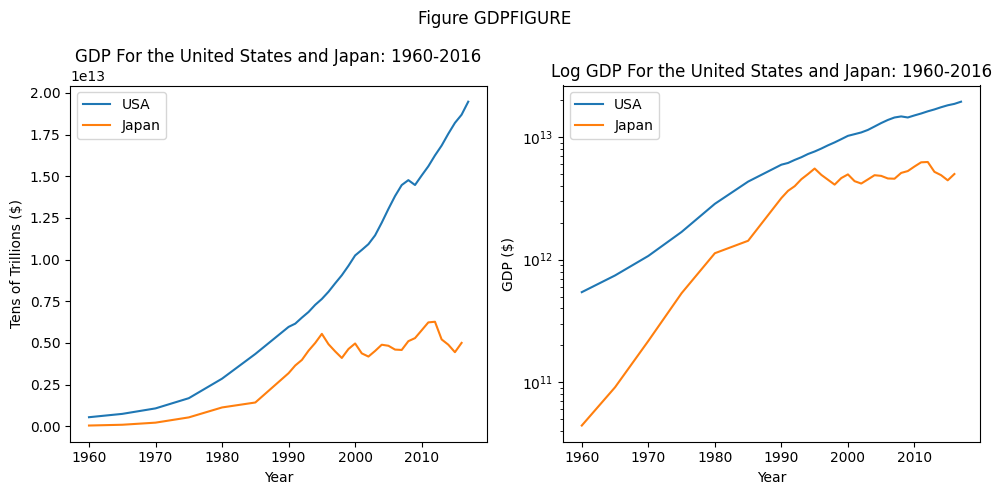

In [9]:
# Plot initial results
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.gca().yaxis.get_offset_text().set_visible(False)
USA.plot(x="Year", y="GDP", ax=axs[0], label="USA")
JAPAN.plot(x="Year", y="GDP", ax=axs[0], label="Japan")
axs[0].set_title("GDP For the United States and Japan: 1960-2016")
axs[0].set_ylabel("Tens of Trillions ($)")

# Plot the logged models
axs[1].set_yscale("log")
USA.plot(x="Year", y="GDP", ax=axs[1], label="USA")
JAPAN.plot(x="Year", y="GDP", ax=axs[1], label="Japan")
axs[1].set_title("Log GDP For the United States and Japan: 1960-2016")
axs[1].set_ylabel("GDP ($)")
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.suptitle("Figure GDPFIGURE")
plt.tight_layout()
plt.show()

These graphs indicate that GDP grows exponentially, especially in the case of the United States. TODO: IS THERE RESEARCH WE CAN CITE THAT SUPPORTS THIS? I'M PRETTY SURE EVERYONE AGREES THAT GDP IS EXPONENTIAL. The log GDP graph is approximately linear, especially with the United States, indicating that the trend $T_t$ should be of the form $T_t = \beta_1 t + \beta_0 $. The seasonal component $S_t$ doesn't appear significant in this graph, so we will assume $ S_t = 0 $. 

Since there isn't a seasonality aspect to this data, a moving averages model will not help us estimate the trend $T_t$. However, running a simple linear regression on the data can help us estimate the parameters $ \hat{\beta_0}, \hat{\beta_1}$. 

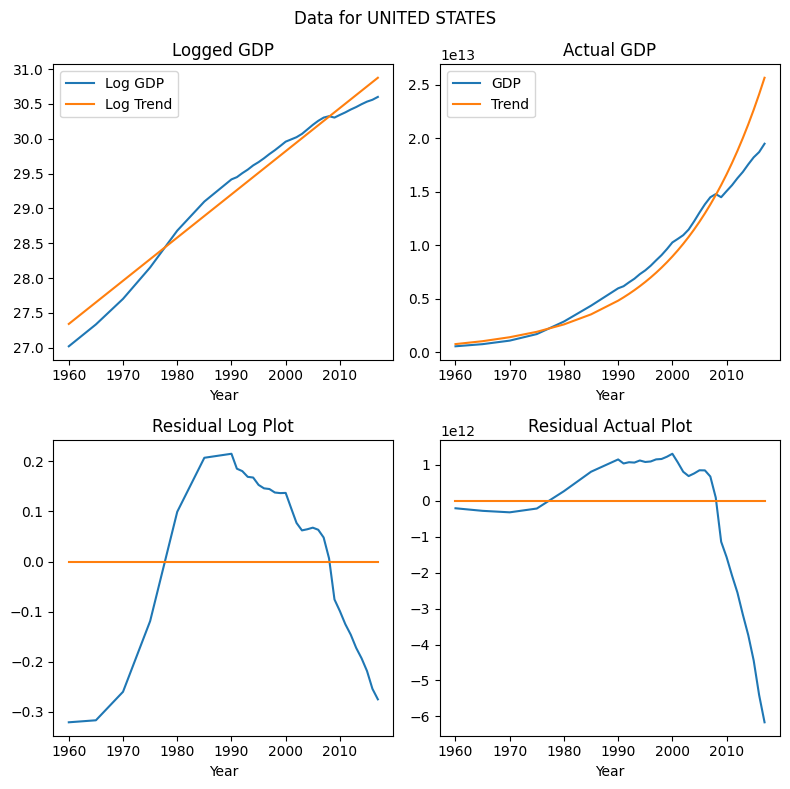

In [50]:
def FitTrendAndPlot(df):
    '''df - the dataframe of the country data'''
    df['log_GDP'] = np.log(df['GDP'])
    y = df['log_GDP']
    X = sm.add_constant(df['Year'])

    model = sm.OLS(y, X).fit()
    modelPrediction = model.predict(X)

    # Plot the results, both logged and the original
    fig, axs = plt.subplots(2,2, figsize=(8,8))

    df.plot(y='log_GDP', x='Year', ax=axs[0,0], label="Log GDP")
    axs[0,0].plot(df['Year'], modelPrediction, label="Log Trend")
    axs[0,0].set_title(f"Logged GDP")
    axs[0,0].legend()

    df.plot(y='GDP', x='Year', ax=axs[0,1], label="GDP")
    axs[0,1].plot(df['Year'], np.exp(modelPrediction), label="Trend")
    axs[0,1].set_title(f"Actual GDP")
    axs[0,1].legend()

    # De-trend the plots
    df['detrended_log_GDP'] = df['log_GDP'] - modelPrediction
    df.plot(y='detrended_log_GDP', x='Year', ax=axs[1,0], legend=False)
    axs[1,0].plot(df['Year'], np.zeros_like(df['Year']))
    axs[1,0].set_title("Residual Log Plot")

    axs[1,1].plot(df['Year'], df['GDP'] - np.exp(modelPrediction))
    axs[1,1].plot(df['Year'], np.zeros_like(df['Year']))
    axs[1,1].set_title("Residual Actual Plot")
    axs[1,1].set_xlabel("Year")
    plt.suptitle(f"Data for {df['Country'][0]}")
    plt.tight_layout()
    plt.show()

    # TODO: Display the parameters b_0 and b_1, consider dropping the "actual" plots.

    return model

model = FitTrendAndPlot(USA)

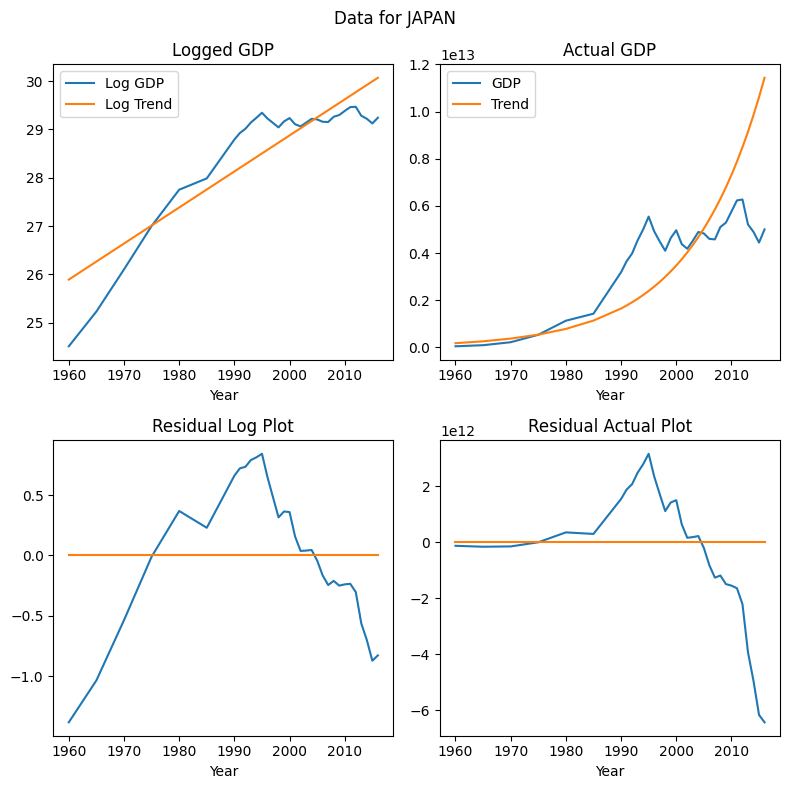

In [51]:
modelJapan = FitTrendAndPlot(JAPAN)

TODO: UPDATE THIS. GDP growth about constant, sometimes overperformed, sometimes underperformed. It is clear that the residual plots for both the United States and Japan are not covariance-stationary. The residual plots are centered around 0, but there is a clear non-random shape to these graphs, implying that the expected value of Z is dependent on time. Therefore, a linear multiplicative model is not sufficient to explain all of the variation in the data. Instead of de-trending further, we will turn our focus to ARMA models and the Kalman Filter to better understand GDP trends.